# Small Runnable Experiment

Instructions note: adjust epochs in each cell as desired. Each cell can be ran independently of the others.

Note: All code produced with assistance from ChatGPT 5.1

In [9]:
"""
Sudoku solver + Hessian-sharpness experiment.
Runs for multiple optimizers (SGD, Adam) × multiple learning rates.
Saves losses, sharpness values, and plots.

"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
import pickle

# ============================================================
# Omit Muon optimizer, use next cell for it
# ============================================================
MUON_AVAILABLE = False

# ============================================================
# Dataset wrapper
# ============================================================
class SudokuHFDataset(Dataset):
    def __init__(self, split="train", max_size=None):
        ds = load_dataset("sapientinc/sudoku-extreme", split=split)
        if max_size is not None:
            ds = ds.select(range(min(max_size, len(ds))))
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        puzzle_str = self.ds[idx]["question"].replace(".", "0")
        sol_str    = self.ds[idx]["answer"]

        puzzle = np.array([int(c) for c in puzzle_str], dtype=np.int64)
        sol    = np.array([int(c) for c in sol_str],    dtype=np.int64)

        x = np.zeros((81, 10), dtype=np.float32)
        for i, v in enumerate(puzzle):
            x[i, v] = 1.0

        x = x.reshape(810)
        y = sol - 1
        return x, y


# ============================================================
# Model
# ============================================================
class SudokuNet(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(810, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 729),
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 81, 9)


# ============================================================
# Hessian sharpness (λ_max)
# ============================================================
def hessian_largest_eigval(model, loss_fn, x, y, device="cpu", num_iters=10):
    """
    Implementation of Hessian λ_max using power iteration.

    """
    model.eval()
    x, y = x.to(device), y.to(device)

    def grad_vec():
        out = model(x)
        loss = loss_fn(out.view(-1, 9), y.view(-1))
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        return torch.cat([g.reshape(-1) for g in grads])

    # Initial vector
    v = torch.randn_like(grad_vec())
    v /= (v.norm() + 1e-12)

    # Power iteration
    for _ in range(num_iters):
        g  = grad_vec()
        Hv = torch.autograd.grad(
            g, model.parameters(), grad_outputs=v,
            retain_graph=True, create_graph=True
        )
        Hv_vec = torch.cat([h.reshape(-1) for h in Hv])
        v = Hv_vec / (Hv_vec.norm() + 1e-12)

    # Rayleigh quotient
    g  = grad_vec()
    Hv = torch.autograd.grad(g, model.parameters(), grad_outputs=v)
    Hv_vec = torch.cat([h.reshape(-1) for h in Hv])
    return torch.dot(v, Hv_vec).item()


# ============================================================
# Training loop for a single optimizer + lr
# ============================================================
def run_training(
    optimizer_name,
    model_constructor,
    optimizer_constructor,
    lr,
    device,
    epochs,
    batch_size,
    hidden_dim,
    num_train,
    num_test,
    print_every,
):
    train_ds = SudokuHFDataset("train", max_size=num_train)
    test_ds  = SudokuHFDataset("test",  max_size=num_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    model    = model_constructor(hidden_dim=hidden_dim).to(device)
    loss_fn  = nn.CrossEntropyLoss()
    optimizer = optimizer_constructor(model.parameters(), lr=lr)

    train_losses   = []
    test_losses    = []
    sharpness_vals = []

    iteration = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            iteration += 1
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out  = model(x)
            loss = loss_fn(out.view(-1, 9), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if iteration % print_every == 0:
                print(f"[{optimizer_name} | lr={lr:.4g}] Iter {iteration}: loss={loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- test loss ---
        model.eval()
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        with torch.no_grad():
            out_val   = model(test_x)
            test_loss = loss_fn(out_val.view(-1, 9), test_y.view(-1)).item()
        test_losses.append(test_loss)

        # --- sharpness ---
        eigval = hessian_largest_eigval(model, loss_fn, test_x, test_y, device=device)
        sharpness_vals.append(eigval)

        print(f"[{optimizer_name} | lr={lr:.4g}] Epoch {epoch}/{epochs}: "
              f"train_loss={avg_train_loss:.4f}  test_loss={test_loss:.4f}  λ_max={eigval:.4f}")

    return {
        "train_losses":   train_losses,
        "test_losses":    test_losses,
        "sharpness_vals": sharpness_vals,
    }


# ============================================================
# Full experiment sweep across optimizers and LRs
# ============================================================
def main_sweep(
    *,
    device,
    epochs,
    batch_size,
    hidden_dim,
    num_train,
    num_test,
    print_every,
    lrs,
    seed=0,
):
    # ----------------------------
    # Set random seed for reproducibility
    # ----------------------------
    torch.manual_seed(seed)
    np.random.seed(seed)

    os.makedirs("results", exist_ok=True)
    results_all = {}

    # --- optimizer constructors ---
    optimizers = {
        "SGD":  lambda params, lr: optim.SGD(params, lr=lr),
        "Adam": lambda params, lr: optim.Adam(params, lr=lr),
    }

    if MUON_AVAILABLE:
        def make_muon(params, lr):
            hidden_weights = [p for p in params if p.ndim >= 2]
            other_params   = [p for p in params if p.ndim < 2]
            param_groups = [
                {"params": hidden_weights, "use_muon": True, "lr": lr},
                {"params": other_params,   "use_muon": False, "lr": lr / 10.0},
            ]
            return MuonWithAuxAdam(param_groups)
        optimizers["Muon"] = make_muon

    # ----------------------------
    # Run sweeps
    # ----------------------------
    for opt_name, opt_fn in optimizers.items():
        results_all[opt_name] = {}
        plt.figure(figsize=(10, 6))

        for lr in lrs:
            print(f"\n### Running {opt_name} with lr={lr:.4g}")

            result = run_training(
                optimizer_name       = opt_name,
                model_constructor    = SudokuNet,
                optimizer_constructor=lambda p, lr=lr: opt_fn(p, lr),
                lr=lr,
                device=device,
                epochs=epochs,
                batch_size=batch_size,
                hidden_dim=hidden_dim,
                num_train=num_train,
                num_test=num_test,
                print_every=print_every,
            )

            results_all[opt_name][lr] = result

            # Save raw data
            fname = f"results/{opt_name}_lr{lr:.4g}.npz"
            np.savez(
                fname,
                train_losses=np.array(result["train_losses"]),
                test_losses=np.array(result["test_losses"]),
                sharpness_vals=np.array(result["sharpness_vals"]),
            )
            print(f"Saved data → {fname}")

            # Individual sharpness plot
            plt_ind = plt.figure(figsize=(8, 4))
            plt.plot(range(1, len(result["sharpness_vals"]) + 1),
                     result["sharpness_vals"], marker='o')
            plt.title(f"{opt_name} – lr={lr:.4g} – Hessian Sharpness")
            plt.xlabel("Epoch")
            plt.ylabel("λₘₐₓ")
            plt.grid(True)
            plt.tight_layout()
            plot_fname = f"results/{opt_name}_lr{lr:.4g}_sharpness.png"
            plt.savefig(plot_fname)
            plt.close(plt_ind)
            print(f"Saved plot → {plot_fname}")

            # Add to combined plot
            plt.plot(range(1, len(result["sharpness_vals"]) + 1),
                     result["sharpness_vals"],
                     lw=2, label=f"lr={lr:g}")

        # Combined optimizer-specific plot
        plt.title(f"Hessian Sharpness vs Epochs – {opt_name}")
        plt.xlabel("Epoch")
        plt.ylabel("λₘₐₓ")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.tight_layout()
        combined_path = f"results/{opt_name}_combined_sharpness.png"
        plt.savefig(combined_path)
        plt.close()
        print(f"Saved combined plot → {combined_path}")

    # Save everything
    with open("results/all_results.pkl", "wb") as f:
        pickle.dump(results_all, f)

    print("Saved full results dictionary to results/all_results.pkl")

    return results_all


# ============================================================
# Entry point
# ============================================================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    sweep_results = main_sweep(
        device=device,
        epochs=5,
        batch_size=128,
        hidden_dim=512,
        num_train=2000,
        num_test=500,
        print_every=100,
        lrs=[1e-1, 5e-2, 1e-2, 1e-3],
        seed=42,   
    )


Using device: cpu

### Running SGD with lr=0.1


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[SGD | lr=0.1] Epoch 1/5: train_loss=2.2917  test_loss=2.2401  λ_max=4.4451
[SGD | lr=0.1] Epoch 2/5: train_loss=2.2215  test_loss=2.2118  λ_max=3.5454
[SGD | lr=0.1] Epoch 3/5: train_loss=2.2029  test_loss=2.2047  λ_max=3.0534
[SGD | lr=0.1] Epoch 4/5: train_loss=2.1968  test_loss=2.2021  λ_max=2.8718
[SGD | lr=0.1] Epoch 5/5: train_loss=2.1932  test_loss=2.2006  λ_max=2.7883
Saved data → results/SGD_lr0.1.npz
Saved plot → results/SGD_lr0.1_sharpness.png

### Running SGD with lr=0.05


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[SGD | lr=0.05] Epoch 1/5: train_loss=2.3133  test_loss=2.2816  λ_max=4.9259
[SGD | lr=0.05] Epoch 2/5: train_loss=2.2552  test_loss=2.2438  λ_max=4.3935
[SGD | lr=0.05] Epoch 3/5: train_loss=2.2248  test_loss=2.2256  λ_max=3.8416
[SGD | lr=0.05] Epoch 4/5: train_loss=2.2104  test_loss=2.2162  λ_max=3.5538
[SGD | lr=0.05] Epoch 5/5: train_loss=2.2031  test_loss=2.2118  λ_max=3.0441
Saved data → results/SGD_lr0.05.npz
Saved plot → results/SGD_lr0.05_sharpness.png

### Running SGD with lr=0.01


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[SGD | lr=0.01] Epoch 1/5: train_loss=2.3380  test_loss=2.3346  λ_max=4.5474
[SGD | lr=0.01] Epoch 2/5: train_loss=2.3219  test_loss=2.3229  λ_max=4.6507
[SGD | lr=0.01] Epoch 3/5: train_loss=2.3080  test_loss=2.3119  λ_max=4.8248
[SGD | lr=0.01] Epoch 4/5: train_loss=2.2954  test_loss=2.3013  λ_max=4.9706
[SGD | lr=0.01] Epoch 5/5: train_loss=2.2837  test_loss=2.2912  λ_max=4.7245
Saved data → results/SGD_lr0.01.npz
Saved plot → results/SGD_lr0.01_sharpness.png

### Running SGD with lr=0.001


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[SGD | lr=0.001] Epoch 1/5: train_loss=2.3401  test_loss=2.3396  λ_max=4.4285
[SGD | lr=0.001] Epoch 2/5: train_loss=2.3381  test_loss=2.3379  λ_max=4.1934
[SGD | lr=0.001] Epoch 3/5: train_loss=2.3360  test_loss=2.3363  λ_max=4.2451
[SGD | lr=0.001] Epoch 4/5: train_loss=2.3346  test_loss=2.3347  λ_max=4.5975
[SGD | lr=0.001] Epoch 5/5: train_loss=2.3327  test_loss=2.3331  λ_max=4.6725
Saved data → results/SGD_lr0.001.npz
Saved plot → results/SGD_lr0.001_sharpness.png
Saved combined plot → results/SGD_combined_sharpness.png

### Running Adam with lr=0.1


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Adam | lr=0.1] Epoch 1/5: train_loss=20.0038  test_loss=13.7378  λ_max=3.2941
[Adam | lr=0.1] Epoch 2/5: train_loss=5.8520  test_loss=3.3114  λ_max=41.5683
[Adam | lr=0.1] Epoch 3/5: train_loss=2.5628  test_loss=2.3442  λ_max=20.0349
[Adam | lr=0.1] Epoch 4/5: train_loss=2.2562  test_loss=2.2288  λ_max=35.9953
[Adam | lr=0.1] Epoch 5/5: train_loss=2.2143  test_loss=2.2104  λ_max=30.9701
Saved data → results/Adam_lr0.1.npz
Saved plot → results/Adam_lr0.1_sharpness.png

### Running Adam with lr=0.05


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Adam | lr=0.05] Epoch 1/5: train_loss=10.6762  test_loss=4.6475  λ_max=2.5488
[Adam | lr=0.05] Epoch 2/5: train_loss=3.4288  test_loss=2.3598  λ_max=6.4055
[Adam | lr=0.05] Epoch 3/5: train_loss=2.3116  test_loss=2.2350  λ_max=8.6080
[Adam | lr=0.05] Epoch 4/5: train_loss=2.2184  test_loss=2.2062  λ_max=8.4406
[Adam | lr=0.05] Epoch 5/5: train_loss=2.2017  test_loss=2.1999  λ_max=8.5189
Saved data → results/Adam_lr0.05.npz
Saved plot → results/Adam_lr0.05_sharpness.png

### Running Adam with lr=0.01


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Adam | lr=0.01] Epoch 1/5: train_loss=2.7799  test_loss=2.3822  λ_max=1.3429
[Adam | lr=0.01] Epoch 2/5: train_loss=2.3121  test_loss=2.2628  λ_max=0.7268
[Adam | lr=0.01] Epoch 3/5: train_loss=2.2437  test_loss=2.2372  λ_max=0.4596
[Adam | lr=0.01] Epoch 4/5: train_loss=2.2274  test_loss=2.2281  λ_max=0.5437
[Adam | lr=0.01] Epoch 5/5: train_loss=2.2172  test_loss=2.2159  λ_max=0.4820
Saved data → results/Adam_lr0.01.npz
Saved plot → results/Adam_lr0.01_sharpness.png

### Running Adam with lr=0.001


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Adam | lr=0.001] Epoch 1/5: train_loss=2.2353  test_loss=2.2084  λ_max=1.3908
[Adam | lr=0.001] Epoch 2/5: train_loss=2.1754  test_loss=2.1827  λ_max=2.4504
[Adam | lr=0.001] Epoch 3/5: train_loss=2.0476  test_loss=2.1428  λ_max=7.6098
[Adam | lr=0.001] Epoch 4/5: train_loss=1.8365  test_loss=2.0762  λ_max=10.1221
[Adam | lr=0.001] Epoch 5/5: train_loss=1.6249  test_loss=2.0405  λ_max=12.0510
Saved data → results/Adam_lr0.001.npz
Saved plot → results/Adam_lr0.001_sharpness.png
Saved combined plot → results/Adam_combined_sharpness.png
✅ Saved full results dictionary to results/all_results.pkl


# Muon

In [7]:
#!/usr/bin/env python3
"""
Sudoku solver — Muon optimizer
----------------------------------------------------
Trains a Sudoku neural network using the Muon optimizer and measures Hessian sharpness.
Runs a learning-rate sweep and saves results + plots in ./results_muon/

"""

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
import pickle
import torch.distributed as dist


# ============================================================
# ---- SINGLE-PROCESS PATCH FOR MUON ----
# ============================================================
def _sp_true(*args, **kwargs): return True
def _sp_zero(*args, **kwargs): return 0
def _sp_one(*args, **kwargs):  return 1
def _sp_none(*args, **kwargs): return None

def _sp_all_gather(tensor_list, tensor, *args, **kwargs):
    """Stub replacement for dist.all_gather in single-process mode."""
    if isinstance(tensor_list, (list, tuple)) and len(tensor_list) > 0:
        for i in range(len(tensor_list)):
            if hasattr(tensor_list[i], "data") and hasattr(tensor, "data"):
                tensor_list[i].data.copy_(tensor.data)
            else:
                tensor_list[i].copy_(tensor)
    return None

dist.is_initialized = _sp_true
dist.get_rank = _sp_zero
dist.get_world_size = _sp_one
dist.barrier = _sp_none
dist.broadcast_object_list = _sp_none
dist.all_gather = _sp_all_gather


# ============================================================
# Import Muon optimizer
# ============================================================
try:
    from muon import MuonWithAuxAdam
except ImportError:
    raise ImportError(
        "\n Muon optimizer not found."
    )


# ============================================================
# Dataset
# ============================================================
class SudokuHFDataset(Dataset):
    def __init__(self, split="train", max_size=None):
        ds = load_dataset("sapientinc/sudoku-extreme", split=split)
        if max_size is not None:
            ds = ds.select(range(min(max_size, len(ds))))
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        puzzle_str = self.ds[idx]["question"].replace(".", "0")
        sol_str = self.ds[idx]["answer"]

        puzzle = np.array([int(c) for c in puzzle_str], dtype=np.int64)
        sol = np.array([int(c) for c in sol_str], dtype=np.int64)

        x = np.zeros((81, 10), dtype=np.float32)
        for i, v in enumerate(puzzle):
            x[i, v] = 1.0
        x = x.reshape(81 * 10)
        y = sol - 1
        return x, y


# ============================================================
# Model
# ============================================================
class SudokuNet(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(81 * 10, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 81 * 9),
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1, 81, 9)


# ============================================================
# Hessian sharpness (λ_max)
# ============================================================
def hessian_largest_eigval(model, loss_fn, x, y, device="cpu", num_iters=10):
    """
    Implementation of Hessian λ_max using power iteration.

    """
    model.eval()
    x, y = x.to(device), y.to(device)

    def grad_vec():
        out = model(x)
        loss = loss_fn(out.view(-1, 9), y.view(-1))
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        return torch.cat([g.reshape(-1) for g in grads])

    # Initial unit vector
    v = torch.randn_like(grad_vec())
    v /= (v.norm() + 1e-12)

    # Power iteration
    for _ in range(num_iters):
        g = grad_vec()
        Hv = torch.autograd.grad(
            g,
            model.parameters(),
            grad_outputs=v,
            retain_graph=True,
            create_graph=True,
        )
        Hv_vec = torch.cat([h.reshape(-1) for h in Hv])
        v = Hv_vec / (Hv_vec.norm() + 1e-12)

    # Final Rayleigh quotient
    g = grad_vec()
    Hv = torch.autograd.grad(g, model.parameters(), grad_outputs=v)
    Hv_vec = torch.cat([h.reshape(-1) for h in Hv])
    eigval = torch.dot(v, Hv_vec).item()
    return eigval


# ============================================================
# Training with Muon
# ============================================================
def run_muon_training(
    lr,
    device,
    epochs,
    batch_size,
    hidden_dim,
    num_train,
    num_test,
    print_every=100,
):
    train_ds = SudokuHFDataset("train", max_size=num_train)
    test_ds = SudokuHFDataset("test", max_size=num_test)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = SudokuNet(hidden_dim=hidden_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()

    hidden_weights = [p for p in model.parameters() if p.ndim >= 2]
    other_params = [p for p in model.parameters() if p.ndim < 2]
    param_groups = [
        {"params": hidden_weights, "use_muon": True, "lr": lr},
        {"params": other_params, "use_muon": False, "lr": lr / 10.0},
    ]
    optimizer = MuonWithAuxAdam(param_groups)

    train_losses, test_losses, sharpness_vals = [], [], []
    iteration = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            iteration += 1
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out.view(-1, 9), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if iteration % print_every == 0:
                print(f"[Muon | lr={lr:.4g}] Iter {iteration}: loss={loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation + sharpness on one test batch
        model.eval()
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        with torch.no_grad():
            out_val = model(test_x)
            test_loss = loss_fn(out_val.view(-1, 9), test_y.view(-1)).item()
        test_losses.append(test_loss)

        eigval = hessian_largest_eigval(model, loss_fn, test_x, test_y, device=device)
        sharpness_vals.append(eigval)

        print(
            f"[Muon | lr={lr:.4g}] Epoch {epoch}/{epochs}: "
            f"train_loss={avg_train_loss:.4f}  test_loss={test_loss:.4f}  λ_max={eigval:.4f}"
        )

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "sharpness_vals": sharpness_vals,
    }


# ============================================================
# LR sweep
# ============================================================
def muon_lr_sweep(
    lrs,
    device,
    epochs,
    batch_size,
    hidden_dim,
    num_train,
    num_test,
    print_every=100,
    seed=None,
):
    """
    Run Muon across multiple learning rates and save results.

    If seed is not None, sets torch + numpy seeds for reproducibility.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    os.makedirs("results_muon", exist_ok=True)
    results = {}
    plt.figure(figsize=(10, 6))

    for lr in lrs:
        print(f"\n Running Muon with lr={lr:.4g}")
        res = run_muon_training(
            lr=lr,
            device=device,
            epochs=epochs,
            batch_size=batch_size,
            hidden_dim=hidden_dim,
            num_train=num_train,
            num_test=num_test,
            print_every=print_every,
        )
        results[lr] = res

        # Save raw arrays
        np.savez(
            f"results_muon/Muon_lr{lr:.4g}.npz",
            train_losses=np.array(res["train_losses"]),
            test_losses=np.array(res["test_losses"]),
            sharpness_vals=np.array(res["sharpness_vals"]),
        )

        # Individual sharpness plot
        plt_ind = plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(res["sharpness_vals"]) + 1),
                 res["sharpness_vals"], marker='o')
        plt.title(f"Muon – lr={lr:.4g}")
        plt.xlabel("Epoch")
        plt.ylabel("λₘₐₓ")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"results_muon/Muon_lr{lr:.4g}_sharpness.png")
        plt.close(plt_ind)

        # Add to combined plot
        plt.plot(range(1, len(res["sharpness_vals"]) + 1),
                 res["sharpness_vals"],
                 lw=2, label=f"lr={lr:g}")

    plt.title("Hessian Sharpness vs Epochs – Muon")
    plt.xlabel("Epoch")
    plt.ylabel("λₘₐₓ")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig("results_muon/Muon_combined_sharpness.png")
    plt.close()

    with open("results_muon/muon_all_results.pkl", "wb") as f:
        pickle.dump(results, f)

    print("Saved all results in small_runnable_experiment/results_muon/")
    return results


# ============================================================
# Entry point
# ============================================================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    muon_results = muon_lr_sweep(
        lrs=[1e-1, 5e-2, 1e-2, 1e-3],
        device=device,
        epochs=1,
        batch_size=128,
        hidden_dim=512,
        num_train=2000,
        num_test=500,
        print_every=100,
        seed=42,
    )


Using device: cpu

🔹 Running Muon with lr=0.1


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Muon | lr=0.1] Epoch 1/1: train_loss=2.2035  test_loss=2.1543  λ_max=2.6529

🔹 Running Muon with lr=0.05


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Muon | lr=0.05] Epoch 1/1: train_loss=2.2026  test_loss=2.1387  λ_max=3.6277

🔹 Running Muon with lr=0.01


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Muon | lr=0.01] Epoch 1/1: train_loss=2.2824  test_loss=2.2126  λ_max=4.6680

🔹 Running Muon with lr=0.001


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


[Muon | lr=0.001] Epoch 1/1: train_loss=2.3369  test_loss=2.3310  λ_max=4.6984
Saved all results in small_runnable_experiment/results_muon/


Using device: cpu


Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aradilla/.cache/huggingface/datasets/sapientinc___csv/sapientinc--sudoku-extreme-798989c95bd556dd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Epoch 1/2:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 01/02 | train_loss=1.6766  test_loss=1.5220  cell-acc=39.14%  λ_max=12.4529


Epoch 2/2:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 02/02 | train_loss=1.5251  test_loss=1.5099  cell-acc=40.20%  λ_max=11.4661
Saved metrics to 'results_trm/trm_sudoku_metrics.npz'


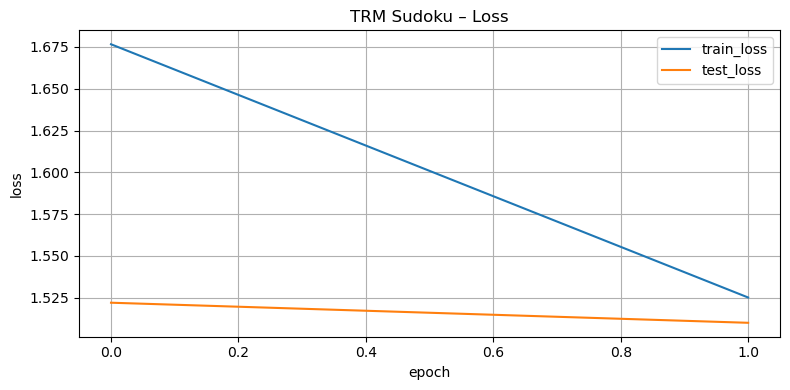

Saved loss plot to 'results_trm/trm_sudoku_loss.png'


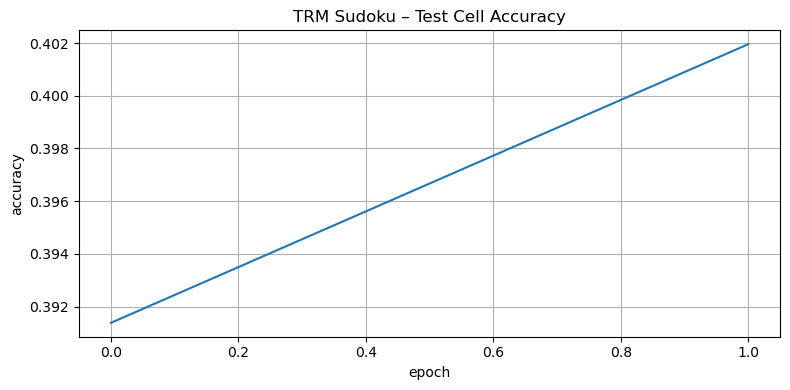

Saved accuracy plot to 'results_trm/trm_sudoku_accuracy.png'


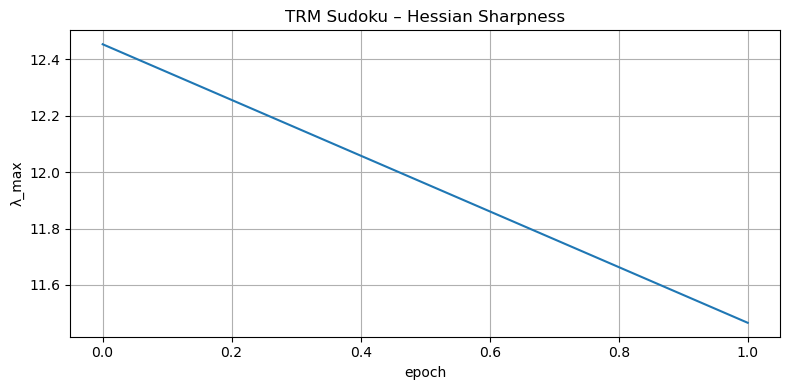

Saved sharpness plot to 'results_trm/trm_sudoku_sharpness.png'
Saved model to 'results_trm/trm_sudoku_model.pth'.


In [12]:
#!/usr/bin/env python3
"""
Sudoku solver with a TRM-style Recursive Transformer + Sharpness
================================================================

- TRM-style model:
    * Token embeddings for digits (0–9), 0 = blank
    * Positional embeddings for 81 cells
    * Pre-LN Transformer blocks with self-attention + MLP
    * Residual connections
    * Repeated application (T steps) of the same block(s)

- Trains on "sapientinc/sudoku-extreme"
- Tracks:
    * train_loss, test_loss, test cell accuracy
    * Hessian sharpness (λ_max via power iteration) each epoch

- Saves:
    * Loss/accuracy/sharpness arrays -> 'trm_sudoku_metrics.npz'
    * Loss plot -> 'trm_sudoku_loss.png'
    * Accuracy plot -> 'trm_sudoku_accuracy.png'
    * Sharpness plot -> 'trm_sudoku_sharpness.png'
    * Model weights -> 'trm_sudoku_model.pth'
"""

import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# ============================================================
# Dataset
# ============================================================
class SudokuHFDataset(Dataset):
    """
    Wraps 'sapientinc/sudoku-extreme'.

    Returns:
        puzzle_onehot: (81*10,) float32 — one-hot of puzzle (unused by TRM, kept for compatibility)
        sol_labels:    (81,) int64 — solution digits encoded as 0–8 (for CE)
        puzzle_digits: (81,) int64 — puzzle digits 0–9 (0 = blank, 1–9 given)
    """
    def __init__(self, split="train", max_size=None):
        ds = load_dataset("sapientinc/sudoku-extreme", split=split)
        if max_size:
            ds = ds.select(range(min(max_size, len(ds))))
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        q = row["question"].replace(".", "0")  # '.' → '0' for blanks
        a = row["answer"]

        puzzle = np.array([int(ch) for ch in q], dtype=np.int64)   # 0–9
        sol    = np.array([int(ch) for ch in a], dtype=np.int64)   # 1–9

        # One-hot puzzle (81×10)
        x = np.zeros((81, 10), dtype=np.float32)
        for i, v in enumerate(puzzle):
            x[i, v] = 1.0
        x = x.reshape(81 * 10)

        # Targets: 1–9 → 0–8
        y = sol - 1

        return x, y, puzzle  # (onehot, labels, puzzle_digits)


# ============================================================
# TRM-style Blocks
# ============================================================
class TRMBlock(nn.Module):
    """
    A single TRM-style Transformer block:

        z -> z + SelfAttention(LN(z))
        z -> z + MLP(LN(z))

    Applied repeatedly T times in TRMModel.
    """
    def __init__(self, emb_dim=64, num_heads=4, mlp_hidden_dim=128, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=emb_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=False,  # expects (L, B, D)
        )
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, emb_dim),
            nn.Dropout(dropout),
        )

    def forward(self, z):
        """
        z: (B, L, D)
        Returns: (B, L, D)
        """
        B, L, D = z.shape

        # Self-attention block with pre-LN
        z_norm = self.ln1(z)               # (B, L, D)
        z_attn_input = z_norm.transpose(0, 1)  # (L, B, D)
        attn_out, _ = self.attn(z_attn_input, z_attn_input, z_attn_input)
        attn_out = attn_out.transpose(0, 1)    # (B, L, D)
        z = z + attn_out                      # Residual

        # MLP block with pre-LN
        z_norm = self.ln2(z)
        mlp_out = self.mlp(z_norm)
        z = z + mlp_out                       # Residual

        return z


class TRMModel(nn.Module):
    """
    TRM-style Sudoku model:

      - token_emb: 10 tokens (0–9), 0 = blank
      - pos_emb:   81 positions (cells)
      - z_0 = token_emb(puzzle_digits) + pos_emb
      - Apply TRMBlock recursively T times
      - Output head: LN(z_T) -> Linear -> 9 logits (digits 1–9) per cell
    """
    def __init__(
        self,
        emb_dim=64,
        num_heads=4,
        mlp_hidden_dim=128,
        num_layers=1,
        T=8,        # number of recursive applications
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.T = T

        # token embedding: digits 0–9
        self.token_emb = nn.Embedding(10, emb_dim)

        # positional embedding for 81 cells
        self.pos_emb = nn.Embedding(81, emb_dim)

        # TRM-style blocks
        self.blocks = nn.ModuleList([
            TRMBlock(emb_dim=emb_dim, num_heads=num_heads, mlp_hidden_dim=mlp_hidden_dim)
            for _ in range(num_layers)
        ])

        # final layer norm & output head
        self.ln_out = nn.LayerNorm(emb_dim)
        self.out_head = nn.Linear(emb_dim, 9)   # logits for digits 1–9

    def forward(self, puzzle_digits):
        """
        puzzle_digits: (B, 81), int64 in [0..9]
        Returns:
            logits: (B, 81, 9)
        """
        device = puzzle_digits.device
        B, L = puzzle_digits.shape
        assert L == 81, "Expecting 81 Sudoku cells"

        # token + positional embeddings
        pos_ids = torch.arange(L, device=device).unsqueeze(0).expand(B, L)  # (B, 81)
        z = self.token_emb(puzzle_digits) + self.pos_emb(pos_ids)           # (B, 81, D)

        # Recursive Transformer updates: apply blocks T times
        for _ in range(self.T):
            for block in self.blocks:
                z = block(z)

        # Final normalization + output head
        z = self.ln_out(z)                    # (B, 81, D)
        logits = self.out_head(z)             # (B, 81, 9)
        return logits


# ============================================================
# Hessian Sharpness via Power Iteration
# ============================================================
def hessian_largest_eigval(
    model,
    loss_fn,
    puzzle_digits,
    y_labels,
    device="cpu",
    num_iters=10,
):
    """
    Estimate the largest eigenvalue λ_max of the (mini-batch) Hessian of the loss
    with respect to model parameters, using power iteration.

    puzzle_digits: (B, 81), int64
    y_labels:      (B, 81), int64 in [0..8]
    """
    model_copy = copy.deepcopy(model).to(device)
    model_copy.eval()
    for p in model_copy.parameters():
        p.requires_grad_(True)

    puzzle_digits = puzzle_digits.to(device)
    y_labels      = y_labels.to(device)

    params = [p for p in model_copy.parameters() if p.requires_grad]

    def grad_vec():
        logits = model_copy(puzzle_digits)          # (B, 81, 9)
        B, N, C = logits.shape
        loss = loss_fn(logits.view(B * N, C), y_labels.view(B * N))
        grads = torch.autograd.grad(
            loss,
            params,
            create_graph=True,
            allow_unused=True,  
        )
        g_flat = torch.cat([
            (torch.zeros_like(p).view(-1) if g is None else g.view(-1))
            for p, g in zip(params, grads)
        ])
        return g_flat

    # Initial v
    v = torch.randn_like(grad_vec())
    v /= (v.norm() + 1e-12)

    # Power iteration
    for _ in range(num_iters):
        g = grad_vec()
        Hv = torch.autograd.grad(
            g,
            params,
            grad_outputs=v,
            retain_graph=True,
            create_graph=True,
            allow_unused=True,
        )
        Hv_flat = torch.cat([
            (torch.zeros_like(p).view(-1) if h is None else h.view(-1))
            for p, h in zip(params, Hv)
        ])
        v = Hv_flat / (Hv_flat.norm() + 1e-12)

    # Rayleigh quotient: v^T H v
    g = grad_vec()
    Hv = torch.autograd.grad(
        g,
        params,
        grad_outputs=v,
        allow_unused=True,
    )
    Hv_flat = torch.cat([
        (torch.zeros_like(p).view(-1) if h is None else h.view(-1))
        for p, h in zip(params, Hv)
    ])
    eigval = torch.dot(v, Hv_flat).item()
    return eigval


# ============================================================
# Training Loop
# ============================================================
def train_trm_sudoku(
    device="cpu",
    emb_dim=64,
    num_heads=4,
    mlp_hidden_dim=128,
    num_layers=1,
    T=8,
    epochs=20,
    batch_size=64,
    lr=3e-4,
    weight_decay=1e-4,
    grad_clip=1.0,
    num_train=2000,
    num_test=500,
    sharp_batch_size=64,
    sharp_num_iters=10,
    seed=42,
):
    # ----- Seeds -----
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # ----- Data -----
    train_ds = SudokuHFDataset("train", max_size=num_train)
    test_ds  = SudokuHFDataset("test",  max_size=num_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=True)

    # A fixed small batch for sharpness (from test set)
    sharp_loader = DataLoader(test_ds, batch_size=sharp_batch_size, shuffle=False, drop_last=True)
    sharp_x_onehot, sharp_y_labels, sharp_puzzle_digits = next(iter(sharp_loader))

    sharp_puzzle_digits = sharp_puzzle_digits.to(device)
    sharp_y_labels      = sharp_y_labels.to(device)

    # ----- Model -----
    model = TRMModel(
        emb_dim=emb_dim,
        num_heads=num_heads,
        mlp_hidden_dim=mlp_hidden_dim,
        num_layers=num_layers,
        T=T,
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    test_losses  = []
    test_accs    = []
    sharpness_vals = []

    os.makedirs("results_trm", exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # -------- Train --------
        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            x_onehot, y_labels, puzzle_digits = batch  # x_onehot unused
            puzzle_digits = puzzle_digits.to(device)   # (B, 81), digits 0–9
            y_labels      = y_labels.to(device)        # (B, 81), labels 0–8

            optimizer.zero_grad()

            logits = model(puzzle_digits)              # (B, 81, 9)
            B, N, C = logits.shape
            loss = loss_fn(logits.view(B * N, C), y_labels.view(B * N))

            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------- Eval on test --------
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            correct = 0
            total = 0
            for batch in test_loader:
                x_onehot, y_labels, puzzle_digits = batch
                puzzle_digits = puzzle_digits.to(device)
                y_labels      = y_labels.to(device)

                logits = model(puzzle_digits)
                B, N, C = logits.shape
                loss = loss_fn(logits.view(B * N, C), y_labels.view(B * N))
                test_loss += loss.item()

                preds = logits.argmax(dim=-1)  # (B, 81), in [0..8]
                correct += (preds == y_labels).sum().item()
                total   += y_labels.numel()

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            test_acc = correct / total
            test_accs.append(test_acc)

        # -------- Hessian sharpness (λ_max) on fixed batch --------
        lambda_max = hessian_largest_eigval(
            model,
            loss_fn,
            sharp_puzzle_digits,
            sharp_y_labels,
            device=device,
            num_iters=sharp_num_iters,
        )
        sharpness_vals.append(lambda_max)

        print(
            f"Epoch {epoch:02d}/{epochs:02d} | "
            f"train_loss={avg_train_loss:.4f}  "
            f"test_loss={avg_test_loss:.4f}  "
            f"cell-acc={test_acc*100:.2f}%  "
            f"λ_max={lambda_max:.4f}"
        )

    # ----- Save metrics -----
    metrics_path = "results_trm/trm_sudoku_metrics.npz"
    np.savez(
        metrics_path,
        train_losses=np.array(train_losses),
        test_losses=np.array(test_losses),
        test_accs=np.array(test_accs),
        sharpness_vals=np.array(sharpness_vals),
    )
    print(f"Saved metrics to '{metrics_path}'")

    # ----- Plots -----
    # Loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="train_loss")
    plt.plot(test_losses, label="test_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("TRM Sudoku – Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    loss_plot_path = "results_trm/trm_sudoku_loss.png"
    plt.savefig(loss_plot_path, dpi=300)
    plt.show()
    print(f"Saved loss plot to '{loss_plot_path}'")

    # Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(test_accs, label="test cell accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("TRM Sudoku – Test Cell Accuracy")
    plt.grid(True)
    plt.tight_layout()
    acc_plot_path = "results_trm/trm_sudoku_accuracy.png"
    plt.savefig(acc_plot_path, dpi=300)
    plt.show()
    print(f"Saved accuracy plot to '{acc_plot_path}'")

    # Sharpness
    plt.figure(figsize=(8, 4))
    plt.plot(sharpness_vals, label="λ_max (Hessian sharpness)")
    plt.xlabel("epoch")
    plt.ylabel("λ_max")
    plt.title("TRM Sudoku – Hessian Sharpness")
    plt.grid(True)
    plt.tight_layout()
    sharp_plot_path = "results_trm/trm_sudoku_sharpness.png"
    plt.savefig(sharp_plot_path, dpi=300)
    plt.show()
    print(f"Saved sharpness plot to '{sharp_plot_path}'")

    # Save model
    model_path = "results_trm/trm_sudoku_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved model to '{model_path}'.")

    return model, {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "test_accs": test_accs,
        "sharpness_vals": sharpness_vals,
    }


# ============================================================
# Run
# ============================================================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    model, logs = train_trm_sudoku(
        device=device,
        emb_dim=64,
        num_heads=4,
        mlp_hidden_dim=128,
        num_layers=1,
        T=8,                 # recursive depth, n_sup
        epochs=2,
        batch_size=64,
        lr=1e-3,
        weight_decay=1e-4,
        grad_clip=1.0,
        num_train=5000,
        num_test=1000,
        sharp_batch_size=64,
        sharp_num_iters=10,
        seed=42,
    )
